imports

In [24]:
from tg.grammar_ru.common import Loc
from tg.grammar_ru.corpus import CorpusReader, CorpusBuilder, BucketCorpusBalancer
from tg.grammar_ru.corpus.corpus_reader import read_data
import os
from pathlib import Path
from dotenv import load_dotenv
from tg.grammar_ru.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.grammar_ru.components.yandex_delivery.training_logs import S3TrainingLogsLoader, TrainingLogsViewer

from yo_fluq_ds import Queryable, Query, fluq
import plotly.express as px

from typing import List, Union
import numpy as np
import math
import pandas as pd
pd.set_option('display.max_rows', 500)
from dotenv import load_dotenv
import matplotlib.pyplot as plt
load_dotenv(Loc.root_path / 'environment.env')
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
import seaborn as sns


### EDA bundle

In [29]:
new = {'ая', 'ого', 'ое', 'ой', 'ом', 'ому',
       'ою', 'ую', 'ые', 'ый', 'ым', 'ыми', 'ых'}

good = {'ая', 'его', 'ее', 'ей', 'ем', 'ему',
        'ие', 'ий', 'им', 'ими', 'их', 'ую', 'яя', 'юю'}

big = {'ая', 'ие', 'им', 'ими', 'их', 'ого',
       'ое', 'ой', 'ом', 'ому', 'ою', 'ую'}

POSSIBLE_ENDINGS = set().union(new, good, big)
endings_nums = {e: i for i, e in enumerate(
    sorted(list(POSSIBLE_ENDINGS)))}
num_by_ending = endings_nums
ending_by_num = {v:k for k, v in endings_nums.items()}

new_declination_labels = {num for e, num in endings_nums.items() if e in new}


In [30]:
{e:num for e,num in num_by_ending.items() if e in new}

{'ая': 0,
 'ого': 11,
 'ое': 12,
 'ой': 13,
 'ом': 14,
 'ому': 15,
 'ою': 16,
 'ую': 17,
 'ые': 18,
 'ый': 19,
 'ым': 20,
 'ыми': 21,
 'ых': 22}

In [32]:
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle
from tg.grammar_ru.components.plain_context_builder import PlainContextBuilder

# db = DataBundle.load(Loc.data_cache_path/'bundles/agreement/mid')
# db['index'] = db.index[db.index.label.isin(new_declination_labels)]
# db = db.copy()
# bundle_1st_declination_path = Loc.data_cache_path/'bundles/agreement/mid_1st_declination'
# db.save(bundle_1st_declination_path)
# idb = IndexedDataBundle(db.index, db)

In [33]:
db = DataBundle.load(Loc.data_cache_path/'bundles/agreement/mid_1st_declination')


In [34]:
db.index.label.unique()

array([18, 11, 19, 22, 13, 12, 17, 14,  0, 15, 20, 21, 16])

In [39]:
import plotly.express as px
fig = px.histogram(db.index.label.replace(ending_by_num), histnorm='probability')
fig.show()

In [33]:
# {ending_by_num[num]:occ_cnt for num, occ_cnt in dict(db.index.label.value_counts()).items()}

In [1]:
project_name = 'agreementproject'
dataset_name = 'agreement_adj_mid_1st_declination'
bucket = 'agreementadjbucket'

In [7]:
import ast 
tasks_list_s3_path = 'datasphere/agreementproject/job_info/job_agreementproject_13:16:45.202308.txt'

tmp_local_file = Loc.temp_path / tasks_list_s3_path.split('/')[-1]
S3YandexHandler.download_file(bucket, tasks_list_s3_path, tmp_local_file)
with open(tmp_local_file,'r') as f:
    tasks = ast.literal_eval(f.read())

print(tasks)
task_name = tasks[0]

['task_50ep_agreement_adj_mid_1st_declination 13:16:45.202363']


output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


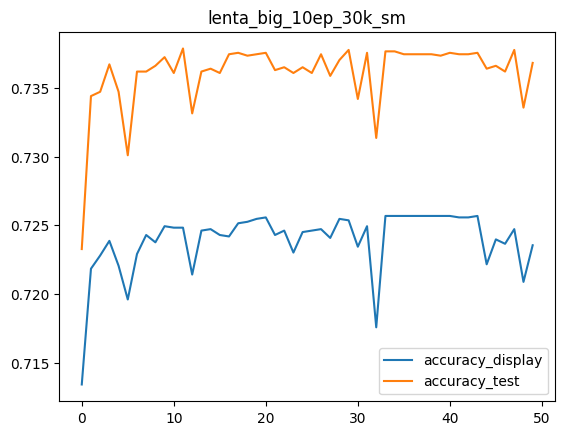

In [6]:
from tg.grammar_ru.components.yandex_delivery.training_logs import S3TrainingLogsLoader, TrainingLogsViewer

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)
plt.plot(TrainingLogsViewer.get_metric_by_job(
    metrics, 'accuracy_display'), label='accuracy_display')
plt.plot(TrainingLogsViewer.get_metric_by_job(
    metrics, 'accuracy_test'), label='accuracy_test')
plt.title('lenta_big_10ep_30k_sm')
plt.legend()

In [52]:
def get_label(s):
    return int(s.split('_label_')[1])

In [53]:
def get_true_and_pred(result_df):
    pred_col_names = [c for c in result_df.columns if 'predicted_label' in c ]
    true_col_names = [c for c in result_df.columns if 'true_label' in c ]
    predicted_probs = result_df[pred_col_names]
    y_pred = result_df[pred_col_names].idxmax(axis="columns").apply(get_label)
    true_probs = result_df[true_col_names]
    y_true = true_probs.idxmax(axis="columns").apply(get_label)

    result_df['pred_label'] = y_pred
    result_df['true_label'] = y_true

    return y_true, y_pred

In [104]:
unzipped_folder = (Loc.root_path /
                   'temp'/'training_results' /
                   f'{task_name}.unzipped')
result_df = pd.read_parquet(unzipped_folder/'output'/'result_df.parquet')
y_true, y_pred = get_true_and_pred(result_df)

In [105]:
sorted_nums = sorted(y_true.unique())
sorted_nums

[0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [133]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                       normalize='true'
                     ).round(2),
    columns=[f'pred {ending_by_num[n]}' for n in sorted_nums],
    index=[f'actual {ending_by_num[n]}' for n in sorted_nums]
)

fig = px.imshow(cm, text_auto=True, color_continuous_scale='blues')
fig.show()

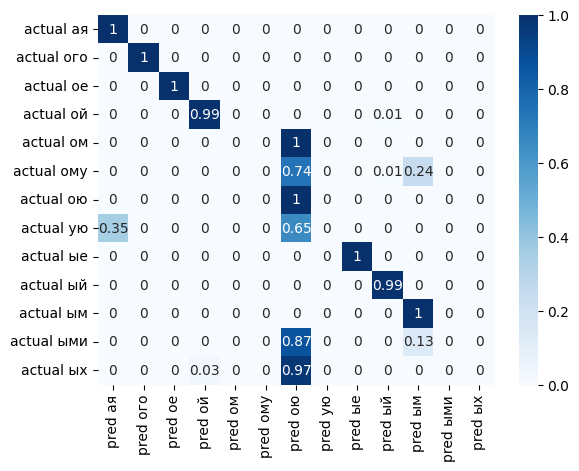

In [134]:
sns.heatmap(cm, annot=cm, cmap="Blues")
plt.yticks(rotation=0) 
plt.show()

In [135]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(z=cm,
                                text=cm,
                                x=cm.columns,
                                y=cm.index,
                                texttemplate="%{text}",
                                colorscale='Blues'))
fig.show()
